# Recurrent Neural Network
This file traines a recurrent neural network on the melspectogram features

In [8]:
import json
import yaml
from pathlib import Path
from lib_util import utils, plot


import numpy as np
import pandas as pd
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping 
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy

from keras.layers import (
    Input,
    GlobalAvgPool1D,
    Dense,
    Bidirectional,
    GRU,
    Dropout,
)
from keras.models import Model, load_model
from keras.optimizers import Adam

from tensorflow.python.ops import math_ops
from tensorflow.python.framework import ops
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import clip_ops

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define crossentropy and accuracy metric for the training routine

For the metric we use a categorial accuracy, for the loss a categorial cross-entropy loss

# Define the model

define the RNN model structure 

In [9]:
def rnn_model(model_config, n_classes):
    """RNN model where the model will be trained on the training data
    """
    d_model = model_config['d_model']
    n_layers = model_config['n_layers']
    init_lr = model_config['init_learning_rate']
    dropout_rate = model_config['dropout_rate']
    activations = model_config['activations']
    dense_layer_class_ratio = model_config['dense_layer_class_ratio']
    inp = Input((None, d_model))
    #Bidirectional means having a neural network in both directions backwards
    x = Bidirectional(GRU(d_model, return_sequences=True))(inp)
    # Making different bidirectional layers 
    if n_classes > 1:
        for i in range(n_layers):
            x = Bidirectional(GRU(d_model, return_sequences=True))(x)

    x = Dropout(dropout_rate)(x)
    x = GlobalAvgPool1D()(x)
    x = Dense(dense_layer_class_ratio * n_classes, activation=activations[0])(x)
    out = Dense(n_classes, activation=activations[1])(x)
    model = Model(inputs=inp, outputs=out)

    loss = CategoricalCrossentropy(
        name='categorial_crossentropy'
    )
    
    metric = CategoricalAccuracy(
        name='categorial_accuracy'
    )
    
    model.compile(
        optimizer=Adam(init_lr), loss=loss, metrics=metric
    )

    model.summary()

    return model

# Main routine

Load the configuration for this model

In [10]:
config = utils.get_config('rnn')

# Extract the values
model_name = config['model_name']
batch_size = config['batch_size']
epochs = config['epochs']

# Load preprocessed data

Load the numpy arrays and the label-class mapping. Split the data accordingly into train, validation and test set

In [11]:
melspec_data = utils.load_sliced_numpy_array('melspec_features')
labels = np.load('data/labels.npy')

labels_to_id = utils.get_class_mapping()

mel_train, mel_test_val, lab_train, lab_test_val = train_test_split(melspec_data, labels, train_size=config['train_set_size'], random_state=config['random_state'])
mel_val, mel_test, lab_val, lab_test             = train_test_split(mel_test_val, lab_test_val, test_size=(config['val_set_size']/(1-config['train_set_size'])), shuffle=False)

# Check the shapes of the splitted sets
assert mel_train.shape[0] == lab_train.shape[0] and mel_test.shape[0] == lab_test.shape[0] and mel_val.shape[0] == lab_val.shape[0]
assert mel_train.shape[1] == mel_test.shape[1] == mel_val.shape[1] and lab_train.shape[1] == lab_test.shape[1] == lab_val.shape[1]

Load slice from file melspec_features_001.npy
Load slice from file melspec_features_002.npy
Load slice from file melspec_features_003.npy
Load slice from file melspec_features_004.npy
Load slice from file melspec_features_005.npy
Load slice from file melspec_features_006.npy
Load slice from file melspec_features_007.npy
Load slice from file melspec_features_008.npy
Load slice from file melspec_features_009.npy
Load slice from file melspec_features_010.npy
Load slice from file melspec_features_011.npy
Load slice from file melspec_features_012.npy
Loaded 12 files as slices, resulting shape: (4068, 33152)


In [12]:
def normalization(mel_train, mel_test, mel_val):
    """Normalize the data files by dividing every data point by the maximum of the train data set
    """
    maximum = np.amax(mel_train)
    mel_train = mel_train/maximum
    mel_test = mel_test/maximum
    mel_val = mel_val/maximum
    return (mel_train.astype(np.float32), mel_test.astype(np.float32), mel_val.astype(np.float32))

mel_train_n, mel_test_n, mel_val_n = normalization(mel_train, mel_test, mel_val)

# Set up the model callbacks

For initializing parameters, refer to the config file. For callbacks, we use a frequently backup of the model as checkpoints, and early stopping mechanism to prevent overfitting on the train data and a learning rate reducer. The learning rate reducer smallers the update step when the validation metric does not improve anymore

In [13]:
from pathlib import Path
train_config = config['training']

checkpoint = ModelCheckpoint(
    Path(config['output_dir'])/f'{model_name}_checkpoint',
    monitor=train_config['monitor'],
    verbose=1,
    save_best_only=train_config['save_best_weights'],
    mode=train_config['monitor_mode'],
    save_weights_only=False
)


es_config = config['training']['early_stopping']
early_stopping = EarlyStopping(
    monitor = es_config['monitor'],
    patience = es_config['patience'],
    verbose = 1,
    mode = es_config['mode'],
    restore_best_weights = True,
    start_from_epoch = es_config['start_from_epoch']
)

# Reduce learning rate when val_loss stopps improving
lr_reduce_config = train_config['lr_reducing']
lr_reducing_on_platteau = ReduceLROnPlateau(
    monitor=lr_reduce_config['monitor'], patience=lr_reduce_config['patience'], min_lr=lr_reduce_config['min_lr'], mode=lr_reduce_config['mode']
    )

# Train routine

In [14]:
# read in the config
pp_config = utils.get_config('preprocess')

n_mels = pp_config['melspectogram']['n_mels']
mel_train_n = mel_train_n.reshape(mel_train_n.shape[0], -1, n_mels)
mel_val_n   = mel_val_n.reshape(mel_val_n.shape[0], -1, n_mels)

model = rnn_model(config['model_structure'], n_classes=len(labels_to_id))

history = model.fit(
        x=mel_train_n,
        y=lab_train,
        validation_data=(mel_val_n, lab_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[checkpoint, lr_reducing_on_platteau, early_stopping],
        use_multiprocessing=True,
        verbose=2
    )


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 128)]       0         
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 256)        198144    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 256)        296448    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, None, 256)        296448    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                           

INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 99s - loss: 1.8726 - categorial_accuracy: 0.2146 - val_loss: 1.6487 - val_categorial_accuracy: 0.3049 - lr: 0.0010 - 99s/epoch - 4s/step
Epoch 2/40

Epoch 2: val_loss improved from 1.64869 to 1.53149, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 88s - loss: 1.5712 - categorial_accuracy: 0.2778 - val_loss: 1.5315 - val_categorial_accuracy: 0.3934 - lr: 0.0010 - 88s/epoch - 4s/step
Epoch 3/40

Epoch 3: val_loss improved from 1.53149 to 1.42993, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 93s - loss: 1.4851 - categorial_accuracy: 0.3755 - val_loss: 1.4299 - val_categorial_accuracy: 0.4098 - lr: 0.0010 - 93s/epoch - 4s/step
Epoch 4/40

Epoch 4: val_loss improved from 1.42993 to 1.38532, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 86s - loss: 1.4170 - categorial_accuracy: 0.3913 - val_loss: 1.3853 - val_categorial_accuracy: 0.4098 - lr: 0.0010 - 86s/epoch - 4s/step
Epoch 5/40

Epoch 5: val_loss improved from 1.38532 to 1.25279, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 97s - loss: 1.2770 - categorial_accuracy: 0.4615 - val_loss: 1.2528 - val_categorial_accuracy: 0.4721 - lr: 0.0010 - 97s/epoch - 4s/step
Epoch 6/40

Epoch 6: val_loss improved from 1.25279 to 1.14370, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 107s - loss: 1.1674 - categorial_accuracy: 0.5086 - val_loss: 1.1437 - val_categorial_accuracy: 0.5328 - lr: 0.0010 - 107s/epoch - 5s/step
Epoch 7/40

Epoch 7: val_loss improved from 1.14370 to 1.07533, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 107s - loss: 1.0594 - categorial_accuracy: 0.5718 - val_loss: 1.0753 - val_categorial_accuracy: 0.5541 - lr: 0.0010 - 107s/epoch - 5s/step
Epoch 8/40

Epoch 8: val_loss did not improve from 1.07533
23/23 - 70s - loss: 1.0894 - categorial_accuracy: 0.5595 - val_loss: 1.0758 - val_categorial_accuracy: 0.5361 - lr: 0.0010 - 70s/epoch - 3s/step
Epoch 9/40

Epoch 9: val_loss improved from 1.07533 to 0.91413, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 103s - loss: 0.9771 - categorial_accuracy: 0.6080 - val_loss: 0.9141 - val_categorial_accuracy: 0.6590 - lr: 0.0010 - 103s/epoch - 4s/step
Epoch 10/40

Epoch 10: val_loss did not improve from 0.91413
23/23 - 66s - loss: 0.8759 - categorial_accuracy: 0.6579 - val_loss: 0.9155 - val_categorial_accuracy: 0.6164 - lr: 0.0010 - 66s/epoch - 3s/step
Epoch 11/40

Epoch 11: val_loss improved from 0.91413 to 0.87063, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 107s - loss: 0.8133 - categorial_accuracy: 0.6923 - val_loss: 0.8706 - val_categorial_accuracy: 0.6459 - lr: 0.0010 - 107s/epoch - 5s/step
Epoch 12/40

Epoch 12: val_loss did not improve from 0.87063
23/23 - 57s - loss: 0.7843 - categorial_accuracy: 0.6993 - val_loss: 0.9174 - val_categorial_accuracy: 0.6311 - lr: 0.0010 - 57s/epoch - 2s/step
Epoch 13/40

Epoch 13: val_loss improved from 0.87063 to 0.81984, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 105s - loss: 0.7391 - categorial_accuracy: 0.7127 - val_loss: 0.8198 - val_categorial_accuracy: 0.6672 - lr: 0.0010 - 105s/epoch - 5s/step
Epoch 14/40

Epoch 14: val_loss did not improve from 0.81984
23/23 - 68s - loss: 0.6729 - categorial_accuracy: 0.7513 - val_loss: 0.8716 - val_categorial_accuracy: 0.6787 - lr: 0.0010 - 68s/epoch - 3s/step
Epoch 15/40

Epoch 15: val_loss did not improve from 0.81984
23/23 - 64s - loss: 0.6206 - categorial_accuracy: 0.7696 - val_loss: 0.9406 - val_categorial_accuracy: 0.6344 - lr: 0.0010 - 64s/epoch - 3s/step
Epoch 16/40

Epoch 16: val_loss improved from 0.81984 to 0.77183, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 93s - loss: 0.6278 - categorial_accuracy: 0.7636 - val_loss: 0.7718 - val_categorial_accuracy: 0.7066 - lr: 0.0010 - 93s/epoch - 4s/step
Epoch 17/40

Epoch 17: val_loss improved from 0.77183 to 0.66467, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 87s - loss: 0.5403 - categorial_accuracy: 0.8019 - val_loss: 0.6647 - val_categorial_accuracy: 0.7639 - lr: 0.0010 - 87s/epoch - 4s/step
Epoch 18/40

Epoch 18: val_loss did not improve from 0.66467
23/23 - 58s - loss: 0.5003 - categorial_accuracy: 0.8163 - val_loss: 0.7818 - val_categorial_accuracy: 0.7344 - lr: 0.0010 - 58s/epoch - 3s/step
Epoch 19/40

Epoch 19: val_loss did not improve from 0.66467
23/23 - 65s - loss: 0.4496 - categorial_accuracy: 0.8405 - val_loss: 0.8240 - val_categorial_accuracy: 0.6934 - lr: 0.0010 - 65s/epoch - 3s/step
Epoch 20/40

Epoch 20: val_loss did not improve from 0.66467
23/23 - 66s - loss: 0.4125 - categorial_accuracy: 0.8528 - val_loss: 0.6764 - val_categorial_accuracy: 0.7623 - lr: 0.0010 - 66s/epoch - 3s/step
Epoch 21/40

Epoch 21: val_loss improved from 0.66467 to 0.60269, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 97s - loss: 0.3169 - categorial_accuracy: 0.8950 - val_loss: 0.6027 - val_categorial_accuracy: 0.7885 - lr: 1.0000e-04 - 97s/epoch - 4s/step
Epoch 22/40

Epoch 22: val_loss improved from 0.60269 to 0.59719, saving model to models/rnn/rnn_checkpoint


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_checkpoint/assets


23/23 - 90s - loss: 0.2912 - categorial_accuracy: 0.9118 - val_loss: 0.5972 - val_categorial_accuracy: 0.7967 - lr: 1.0000e-04 - 90s/epoch - 4s/step
Epoch 23/40

Epoch 23: val_loss did not improve from 0.59719
23/23 - 60s - loss: 0.2790 - categorial_accuracy: 0.9153 - val_loss: 0.6065 - val_categorial_accuracy: 0.7869 - lr: 1.0000e-04 - 60s/epoch - 3s/step
Epoch 24/40

Epoch 24: val_loss did not improve from 0.59719
23/23 - 70s - loss: 0.2760 - categorial_accuracy: 0.9083 - val_loss: 0.6012 - val_categorial_accuracy: 0.7918 - lr: 1.0000e-04 - 70s/epoch - 3s/step
Epoch 25/40

Epoch 25: val_loss did not improve from 0.59719
23/23 - 66s - loss: 0.2640 - categorial_accuracy: 0.9206 - val_loss: 0.6069 - val_categorial_accuracy: 0.7934 - lr: 1.0000e-04 - 66s/epoch - 3s/step
Epoch 26/40

Epoch 26: val_loss did not improve from 0.59719
23/23 - 66s - loss: 0.2514 - categorial_accuracy: 0.9245 - val_loss: 0.6099 - val_categorial_accuracy: 0.7885 - lr: 1.0000e-05 - 66s/epoch - 3s/step
Epoch 27/40

In [15]:
from lib_util import utils

to_dump = {
    'model': model,
    'history': history.history,
    'config': config
}

utils.save_training(to_dump, model_name, dir=config['output_dir'])

INFO:tensorflow:Assets written to: models/rnn/rnn_trained/assets


INFO:tensorflow:Assets written to: models/rnn/rnn_trained/assets


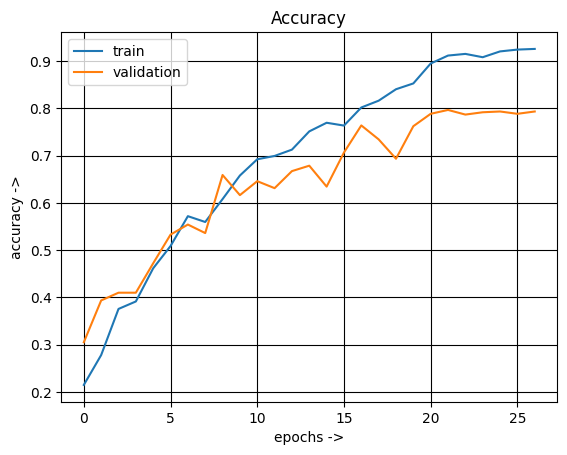

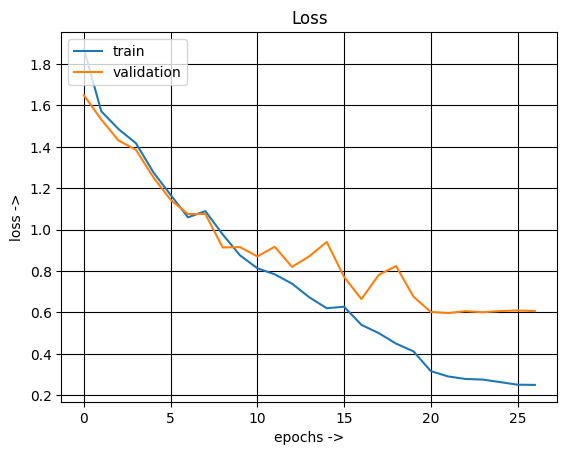

In [16]:
history = utils.load_history(model_name, dir=config['output_dir'])
model_name = config['model_name']

#Plots for the accuracies and losses of the train and validation data per epoch
plot.plot_hist(history, ('categorial_accuracy', 'val_categorial_accuracy'), legends=('train', 'validation'), title='Accuracy', y_label='accuracy ->', x_label='epochs ->', save_to=f'Plots/{model_name}_{epochs}_accuracy')
plot.plot_hist(history, ('loss', 'val_loss'), legends=('train', 'validation'), title='Loss', y_label='loss ->', x_label='epochs ->', save_to=f'Plots/{model_name}_{epochs}_loss')

In [17]:
predict = lambda model, data: np.argmax(model.predict(data), axis=-1)

mel_test_n = mel_test_n.reshape(mel_test_n.shape[0], -1, n_mels)

#Loading in the model
model = utils.load_model(model_name, dir=config['output_dir'])

# Training prediction
y_pred_train = predict(model, mel_train_n)
y_true_train = np.argmax(lab_train, axis= -1)
print(f"ACCURACY FOR TRAIN SET {accuracy_score(y_true_train, y_pred_train)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_train, y_pred_train, average='weighted')*100:.4f} %")


# Validation prediction
y_pred_val = predict(model, mel_val_n)
y_true_val = np.argmax(lab_val, axis= -1)
print(f"ACCURACY FOR VAL SET {accuracy_score(y_true_val, y_pred_val)*100:.4f} %")
print(f"MACRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR VAL SET {f1_score(y_true_val, y_pred_val, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TRAIN SET {f1_score(y_true_val, y_pred_val, average='weighted')*100:.4f} %")


# Test prediction
y_pred_test = predict(model, mel_test_n)
y_true_test = np.argmax(lab_test, axis= -1)
print(f"ACCURACY FOR TEST SET {accuracy_score(y_true_test, y_pred_test)*100:.4f} %")
print(f"MACRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='macro')*100:.4f} %")
print(f"MICRO F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='micro')*100:.4f} %")
print(f"WEIGHTED F1 SCORE FOR TEST SET {f1_score(y_true_test, y_pred_test, average='weighted')*100:.4f} %")

89/89 [==============================] - 20s 210ms/step
ACCURACY FOR TRAIN SET 91.8511 %
MACRO F1 SCORE FOR TRAIN SET 91.2496 %
MICRO F1 SCORE FOR TRAIN SET 91.8511 %
WEIGHTED F1 SCORE FOR TRAIN SET 91.8236 %
20/20 [==============================] - 4s 210ms/step
ACCURACY FOR VAL SET 79.6721 %
MACRO F1 SCORE FOR VAL SET 78.7735 %
MICRO F1 SCORE FOR VAL SET 79.6721 %
WEIGHTED F1 SCORE FOR TRAIN SET 79.6167 %
20/20 [==============================] - 4s 215ms/step
ACCURACY FOR TEST SET 79.7054 %
MACRO F1 SCORE FOR TEST SET 77.6145 %
MICRO F1 SCORE FOR TEST SET 79.7054 %
WEIGHTED F1 SCORE FOR TEST SET 79.5308 %


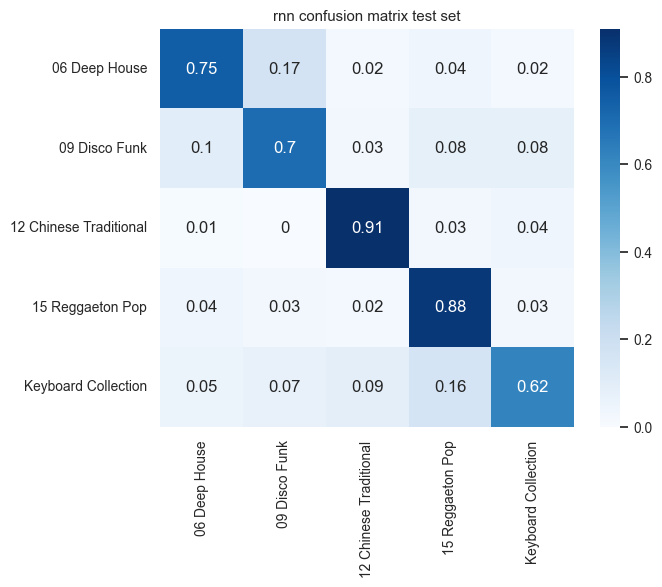

In [18]:
class_names = utils.get_class_names()

#Confusion matrix of the predicted labels versus the true labels
conf_mat = confusion_matrix(y_true_test, y_pred_test, normalize= 'true')
conf_mat = np.round(conf_mat, 2)

conf_mat_df = pd.DataFrame(conf_mat, columns=class_names, index=class_names)

plot.plot_conf_mat(conf_mat_df, save_to=f"Plots/{model_name}_{epochs}_test_conf_mat.png", name=model_name, set_type='test')